In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [39]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x.view(-1, 784))

In [40]:
netG = Generator()
netD = Discriminator()

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

In [41]:
num_epochs = 50
for epoch in range(num_epochs):
    for i, (real, _) in enumerate(train_loader):
        # Train Discriminator
        netD.zero_grad()
        batch_size = real.size(0)
        label = torch.full((batch_size,), 1, dtype=torch.float)
        output = netD(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(batch_size, 100)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        label.fill_(1)
        noise = torch.randn(batch_size, 100)
        fake = netG(noise)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss_D: {(errD_real+errD_fake).item():.4f} Loss_G: {errG.item():.4f}')

Epoch [1/50] Loss_D: 0.1738 Loss_G: 3.9959
Epoch [2/50] Loss_D: 0.0892 Loss_G: 7.1803
Epoch [3/50] Loss_D: 0.7032 Loss_G: 2.8227
Epoch [4/50] Loss_D: 0.4379 Loss_G: 2.5767
Epoch [5/50] Loss_D: 1.8520 Loss_G: 1.4098
Epoch [6/50] Loss_D: 0.9422 Loss_G: 1.9214
Epoch [7/50] Loss_D: 0.8233 Loss_G: 2.4868
Epoch [8/50] Loss_D: 0.4587 Loss_G: 3.5138
Epoch [9/50] Loss_D: 0.3902 Loss_G: 3.4733
Epoch [10/50] Loss_D: 0.6873 Loss_G: 2.2052
Epoch [11/50] Loss_D: 0.8809 Loss_G: 2.3383
Epoch [12/50] Loss_D: 0.5575 Loss_G: 3.0947
Epoch [13/50] Loss_D: 0.7553 Loss_G: 2.1300
Epoch [14/50] Loss_D: 0.5436 Loss_G: 2.2365
Epoch [15/50] Loss_D: 0.6950 Loss_G: 1.8084
Epoch [16/50] Loss_D: 0.2409 Loss_G: 2.6073
Epoch [17/50] Loss_D: 0.2886 Loss_G: 4.3423
Epoch [18/50] Loss_D: 0.4258 Loss_G: 2.8160
Epoch [19/50] Loss_D: 0.3212 Loss_G: 3.4408
Epoch [20/50] Loss_D: 0.4879 Loss_G: 3.6772
Epoch [21/50] Loss_D: 0.6773 Loss_G: 2.4284
Epoch [22/50] Loss_D: 0.3526 Loss_G: 3.5739
Epoch [23/50] Loss_D: 0.5771 Loss_G: 2.88

In [42]:
# outer_epochs = 10
# inner_epochs = 5
#
# for outer_epoch in range(outer_epochs):
#     # Train Discriminator
#     for epoch in range(inner_epochs):
#         for _, (real, _) in enumerate(train_loader):
#             netD.zero_grad()
#             batch_size = real.size(0)
#             label = torch.full((batch_size,), 1, dtype=torch.float)
#             output = netD(real).view(-1)
#             errD_real = criterion(output, label)
#             errD_real.backward()
#
#             noise = torch.randn(batch_size, 100)
#             fake = netG(noise)
#             label.fill_(0)
#             output = netD(fake.detach()).view(-1)
#             errD_fake = criterion(output, label)
#             errD_fake.backward()
#             optimizerD.step()
#
#         print(f'Outer Epoch [{outer_epoch+1}/{outer_epochs}], D: Inner Epoch [{epoch+1}/{inner_epochs}], Loss_D: {(errD_real+errD_fake).item():.4f}')
#
#     # Train Generator
#     for epoch in range(inner_epochs):
#         for _, (_, _) in enumerate(train_loader):
#             # Train Generator
#             netG.zero_grad()
#             noise = torch.randn(batch_size, 100)
#             fake = netG(noise)
#             label = torch.full((batch_size,), 1, dtype=torch.float)
#             output = netD(fake).view(-1)
#             errG = criterion(output, label)
#             errG.backward()
#             optimizerG.step()
#
#         print(f'Outer Epoch [{outer_epoch+1}/{outer_epochs}], G: Inner Epoch [{epoch+1}/{inner_epochs}], Loss_G: {errG.item():.4f}')

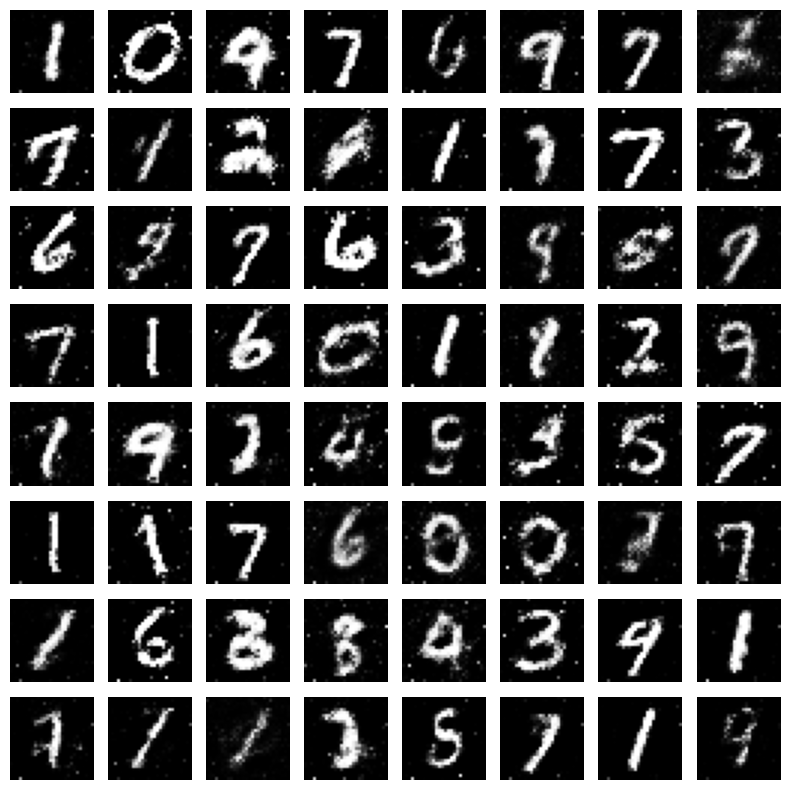

In [43]:
netG.eval()
with torch.no_grad():
    noise = torch.randn(64, 100)
    fake_images = netG(noise).detach().cpu()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i][0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()